# Packages

In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pySODM.models.base import ODEModel
from covid19_DTM.data.utils import construct_initN
from covid19_DTM.models.TDPF import ramp_fun
from covid19_DTM.models.TDPF import make_seasonality_function
import csv
from csv import DictReader
from matplotlib import font_manager
import string
import os

# Data

In [2]:
abs_dir = os.getcwd()
rel_dir = '../../data/PHM/interim/UZG/'
file_name = 'MZG_residence_times.csv'

types_dict = {'APR_MDC_key': str, 'age_group': str, 'stay_type':str}
residence_times = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()
mean_residence_times = residence_times.groupby(by=['APR_MDC_key']).mean()

file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
hospitalization_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
hospitalization_baseline = hospitalization_baseline.groupby(['APR_MDC_key','week_number','day_number']).median()

file_name = 'MZG_Hospitalizations_per_day_before.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_before = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

file_name = 'MZG_Hospitalizations_per_day_covid.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_covid = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

file_name ='MZG_Hospitalizations_per_day_baseline.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()

file_name = 'MZG_covid_hospitalizations_per_day.csv'
types_dict = {'APR_MDC_key': str}
covid_hospitalizations_per_day = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0],dtype=types_dict).squeeze()*2
#covid_hospitalizations_per_day -= 4
#covid_hospitalizations_per_day[np.where(covid_hospitalizations_per_day<0)[0]]=0

MDC_dict={}
file_name = 'MDC_dict.csv'
with open(os.path.join(abs_dir,rel_dir,file_name), mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        MDC_dict.update({row[0]:row[1]})

MDC_keys = hospitalization_baseline.index.get_level_values(0).unique().values
MDC_keys = np.append(MDC_keys,'covid')
MDC_dict.update({'covid':'covid'})
mean_residence_times['covid']=10


# Define model and functions

In [43]:
class postponed_healthcare_model(ODEModel):
    """
    Test model for postponed health_care using a waiting queue before hospitalization
    """
    
    state_names = ['W','H','R','NR','X']
    parameter_names = ['X_tot']
    parameter_stratified_names = ['A','beta','gamma','epsilon','sigma']
    dimension_names = ['MDC']
    dimension_names = ['MDC']
    
    @staticmethod
    def integrate(t, W, H, R, NR, X, A, X_tot, beta, gamma, epsilon, sigma):
        W = np.where(W<0,0,W)
        
        if sum(sigma*W)==0:
            X_new = np.zeros(len(H))
        else:
            X_new = (X_tot-sum(H)) * (sigma*W)/sum(sigma*W)
        dX = X_new-X

        W_to_H = 1/beta*np.where(W>X_new,X_new,W)
        W_to_NR = epsilon*np.where(W>X_new,W,0)
        if (W_to_NR < 0).any():
            print(W)
            print(W_to_H)
            print(W-W_to_H)
            print()
        
        dW = A - W_to_H - W_to_NR
        dH = W_to_H - (1/gamma*H)
        dR = (1/gamma*H)
        dNR = W_to_NR
        
        return dW, dH, dR, dNR, dX

In [4]:
def daily_hospitalizations_func(t, states, param,MDC):

    t_string = t.strftime('%Y-%m-%d')
    #if t_string in covid_hospitalizations_per_day.index.get_level_values(0).values:
        #covid_H = covid_hospitalizations_per_day.loc[t_string]
    #else:
        #covid_H=0
    if t >=pd.Timestamp('2020-01-01'):
        covid_H=covid_hospitalizations_per_day.loc[t_string]
    else:
        covid_H=0

    #week = t.isocalendar().week
    #day = t.isocalendar().weekday
    #daily_hospitalizations = hospitalizations_per_day_baseline.loc[MDC_keys[np.where(MDC_keys!='covid')],week,day].values
    #daily_hospitalizations = np.insert(daily_hospitalizations,np.where(MDC_keys=='covid')[0],covid_H)
    
    if t < pd.Timestamp('2020-01-01'):
        daily_hospitalizations = hospitalizations_per_day_before.loc[(MDC[np.where(MDC!='covid')],t_string)].values
    else:
        daily_hospitalizations = hospitalizations_per_day_covid.loc[(MDC[np.where(MDC!='covid')],t_string)].values
    daily_hospitalizations = np.insert(daily_hospitalizations,np.where(MDC=='covid')[0],covid_H)
    return daily_hospitalizations

In [5]:
def hypothetical_covid_peak(t, states, param,MDC,start_peak,end_peak,peak_amplitude):
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0

    param[np.where(MDC=='covid')]=covid_H
    return param


# Conceptual example

In [83]:
start_sim = pd.to_datetime('2020-12-01')
end_sim = pd.to_datetime('2021-08-01')
sim_time = pd.date_range(start_sim,end_sim)

plot_start_date = pd.to_datetime('2021-01-01')
plot_end_date = pd.to_datetime('2021-08-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

start_peak = pd.to_datetime('2021-02-01')
end_peak = pd.to_datetime('2021-04-01')
peak_amplitude = 20

In [89]:
# Define MDC classes to model
MDC = np.array(['04','covid'])

# Define model parameters, initial states and coordinates
beta = np.ones(len(MDC))*0.5
gamma = np.ones(len(MDC))*7
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))

X_tot = 100

A = np.array([10,0])
params={'A':A,'X_tot':X_tot,'beta':beta, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma,
        'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude,'MDC':MDC}

H_init = np.array([70,0])

init_states = {'H':H_init}
coordinates={'MDC':MDC}
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'A':hypothetical_covid_peak})


In [90]:
out = model.sim([start_sim,end_sim])

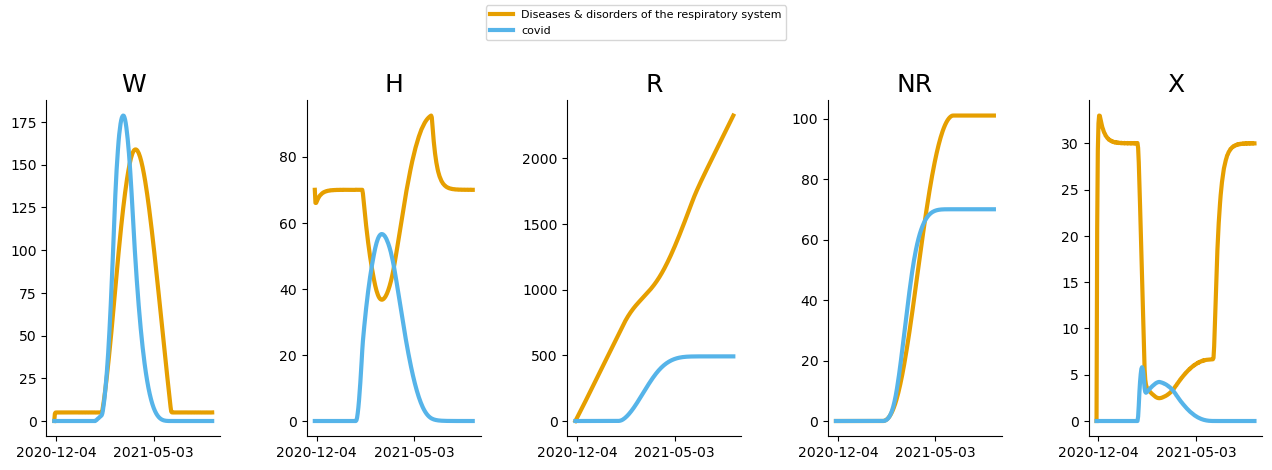

In [91]:
fig, axs = plt.subplots(1,5)
axs = axs.reshape(-1)

label_with = False
label_without = False
idx=0
for state in model.state_names:
    for disease in out.MDC.values:
        out_plot = out.sel(MDC=disease)[state]
        axs[idx].plot(sim_time,out_plot, label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    idx+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

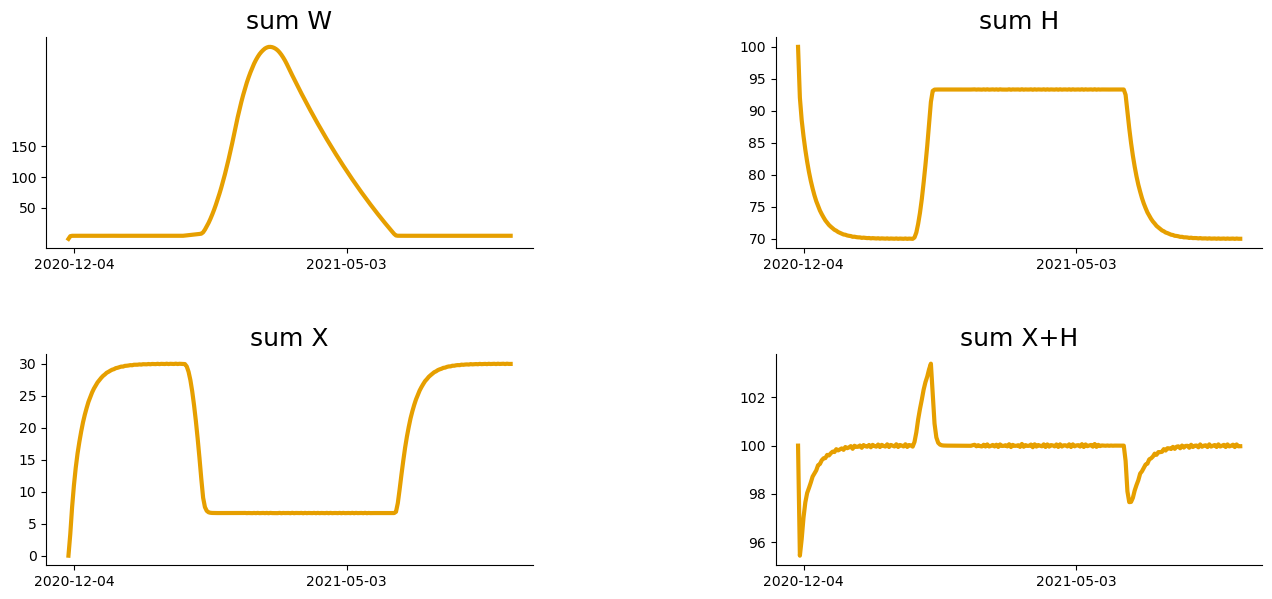

In [88]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state == 'X+H':
        out_plot = out.sum('MDC')['X'] + out.sum('MDC')['H']
    else:
        out_plot = out.sum('MDC')[state]
    axs[idx].plot(sim_time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_yticks

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
axs[0].set_yticks(ticks=[X_tot-50,X_tot,X_tot+50])
plt.show()

## Parameter influences 

In [58]:
abs_dir = os.getcwd()
result_folder = '../../results/PHM/analysis/queuing_model/parameter_influences/'

label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=8)

In [54]:
start_sim = pd.to_datetime('2020-12-01')
end_sim = pd.to_datetime('2021-08-01')

plot_start_date = pd.to_datetime('2021-01-01')
plot_end_date = pd.to_datetime('2021-08-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

start_peak = pd.to_datetime('2021-02-01')
end_peak = pd.to_datetime('2021-04-01')
peak_amplitude = 20

In [72]:
# Define MDC classes to model
MDC = np.array(['04','covid'])

# Define model parameters, initial states and coordinates
beta = np.ones(len(MDC))*0.5
gamma = np.ones(len(MDC))*7
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))

X_tot = 100

A = np.array([10,0])
params={'A':A,'X_tot':X_tot,'beta':beta, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma,
        'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude,'MDC':MDC}

H_init = np.array([100,0])

init_states = {'H':H_init}
coordinates={'MDC':MDC}
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'A':hypothetical_covid_peak})

In [77]:
sigma_covid_choices = [0.5,1,3]
sigma_choices = []
for sigma_covid in sigma_covid_choices:
    sigma_choices.append(np.where(MDC=='covid',sigma_covid,1))

X_tot_choices = [80, 100, 200]

epsilon_choices = [0,0.01,1]
epsilon_choices = np.tile(epsilon_choices,(len(MDC),1)).transpose()

beta_choices = [0.1,0.5,1]
beta_choices = np.tile(beta_choices,(len(MDC),1)).transpose()

parameters = {'sigma':sigma_choices,'X_tot':X_tot_choices,'epsilon':epsilon_choices,'beta':beta_choices}

sigma
X_tot
epsilon
beta
                                                a  \
sigma      [79.95306679574566, 89.72081726510511]   
X_tot    [262.92209668521537, 114.78863578746687]   
epsilon                                [0.0, 0.0]   
beta       [77.32251187719184, 58.75911754834146]   

                                               b  \
sigma    [100.76726369992625, 69.73797272609262]   
X_tot    [100.76726369992625, 69.73797272609262]   
epsilon  [100.76726369992625, 69.73797272609262]   
beta     [100.76726369992625, 69.73797272609262]   

                                                c  
sigma    [126.11783209188089, 44.138931072821876]  
X_tot                                  [0.0, 0.0]  
epsilon  [158.37609001948033, 217.25921564769902]  
beta      [136.73898569503982, 84.07580071674857]  


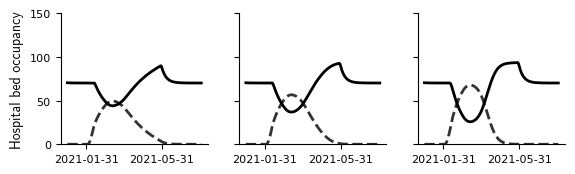

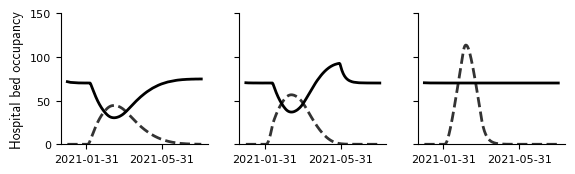

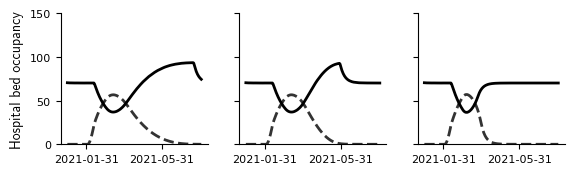

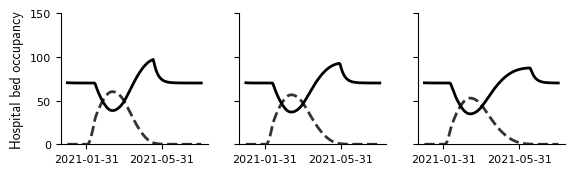

In [78]:
NR_table = pd.DataFrame(index=parameters.keys(),columns=['a','b','c'])

for parameter_name,parameter_choices in parameters.items():
    fig, axs = plt.subplots(1,3,figsize=(6,2),sharey=True,sharex=True)
    print(parameter_name)
    for i,parameter_value in enumerate(parameter_choices):
        model.parameters.update({parameter_name:parameter_value})
        out = model.sim([start_sim,end_sim])
        NR_table[string.ascii_lowercase[i]][parameter_name]=out.NR[-1].values
        for disease in MDC:
            out_plot = out.sel(MDC=disease,date=plot_time)['H']
            if disease == "covid":
                axs[i].plot(plot_time,out_plot,color='black',linestyle='dashed',linewidth=2,alpha=0.8)
            else:
                axs[i].plot(plot_time,out_plot,color='black',linewidth=2)
            axs[i].set_ylim([0,150])
            #axs[i].set_title(f'{string.ascii_lowercase[i]})',font=label_font)
            axs[i].xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='4M'))
            axs[i].tick_params(axis='both', which='major', labelsize=8)
            axs[i].grid(False)
    axs[0].set_ylabel('Hospital bed occupancy',font=label_font)
    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,f'queuing_model_{parameter_name}'),dpi=600,bbox_inches='tight')
    model.parameters.update({parameter_name:globals()[parameter_name]})
print(NR_table)
NR_table.to_csv(os.path.join(result_folder,'NR_table.csv'))


# Fitting real world data

## Before Covid

### Parameters

In [95]:
#set start and end date
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2020-01-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

In [125]:
# Define MDC classes to model
MDC = hospitalizations_per_day_before.index.get_level_values('APR_MDC_key').unique().values
MDC = np.append(MDC,'covid')

# Define model parameters, initial states and coordinates
beta = np.ones(len(MDC))*0.5
gamma = mean_residence_times.loc[MDC].values
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))
sigma[np.where(MDC=='covid')]=10

X_tot = 1049

A = hospitalizations_per_day_before.loc[(MDC,start_date.strftime('%Y-%m-%d'))].values
A = np.append(A,0)
params={'A':A,'X_tot':X_tot,'beta':beta, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma,'MDC':MDC}

H_init = hospitalization_baseline.loc[MDC,start_date.isocalendar().week,start_date.isocalendar().weekday].values
H_init = np.insert(H_init,np.where(MDC=='covid')[0],0)
init_states = {'H':H_init}
coordinates={'MDC':MDC}
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'A': daily_hospitalizations_func})

C:\Users\wolfd\AppData\Local\Temp\ipykernel_2312\2806049019.py:14: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  A = hospitalizations_per_day_before.loc[(MDC,start_date.strftime('%Y-%m-%d'))].values
C:\Users\wolfd\AppData\Local\Temp\ipykernel_2312\2806049019.py:18: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  H_init = hospitalization_baseline.loc[MDC,start_date.isocalendar().week,start_date.isocalendar().weekday].values


In [126]:
out_real_world_before = model.sim([start_date,end_date])

### plot results

In [128]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2018-01-01')
plot_end_date = pd.to_datetime('2020-01-01')
time = pd.date_range(plot_start_date,plot_end_date)
out = out_real_world_before.sel(date=time).copy()

#X = []
#for t in time:
#    X.append(((X_tot-out.sel(time=t).sum('MDC_keys')['H']) * (sigma*out.sel(time=t)['W'])/sum(sigma*out.sel(time=t)['W'])).values)
#X = np.array(X)


#### States


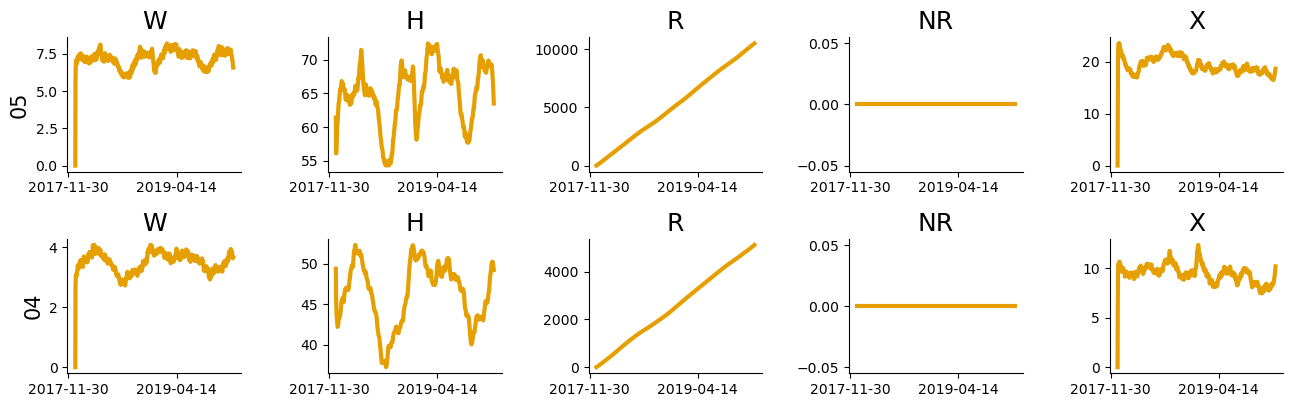

In [131]:
fig, axs = plt.subplots(len(MDC_plot_classes),5)

for disease_idx, disease in enumerate(MDC_plot_classes):
    axs[disease_idx,0].set_ylabel(disease)
    for state_idx, state in enumerate(model.state_names):
        if disease=='04':
            out_plot = out.sel(MDC=disease)[state]+out.sel(MDC='covid')[state]
        else:
            out_plot = out.sel(MDC=disease)[state].copy()
        axs[disease_idx,state_idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[disease_idx,state_idx].set_title(state)
        axs[disease_idx,state_idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[disease_idx,state_idx].grid(False)
        axs[disease_idx,state_idx].tick_params(axis='both', which='major', labelsize=10)
        axs[disease_idx,state_idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)

#### X-H

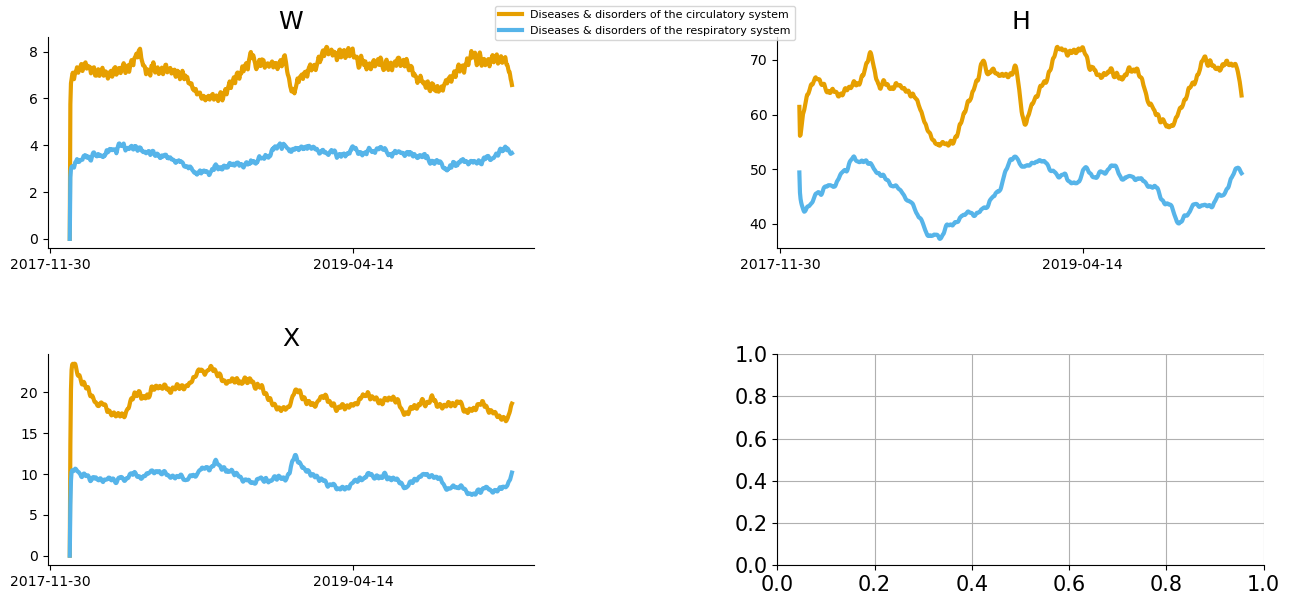

In [133]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X']):
    for dis_idx, disease in enumerate(MDC_plot_classes):
        out_plot = out.sel(MDC=disease)[state].copy()
        axs[idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,fontsize=8,loc='upper center')
plt.show()

#### Sum

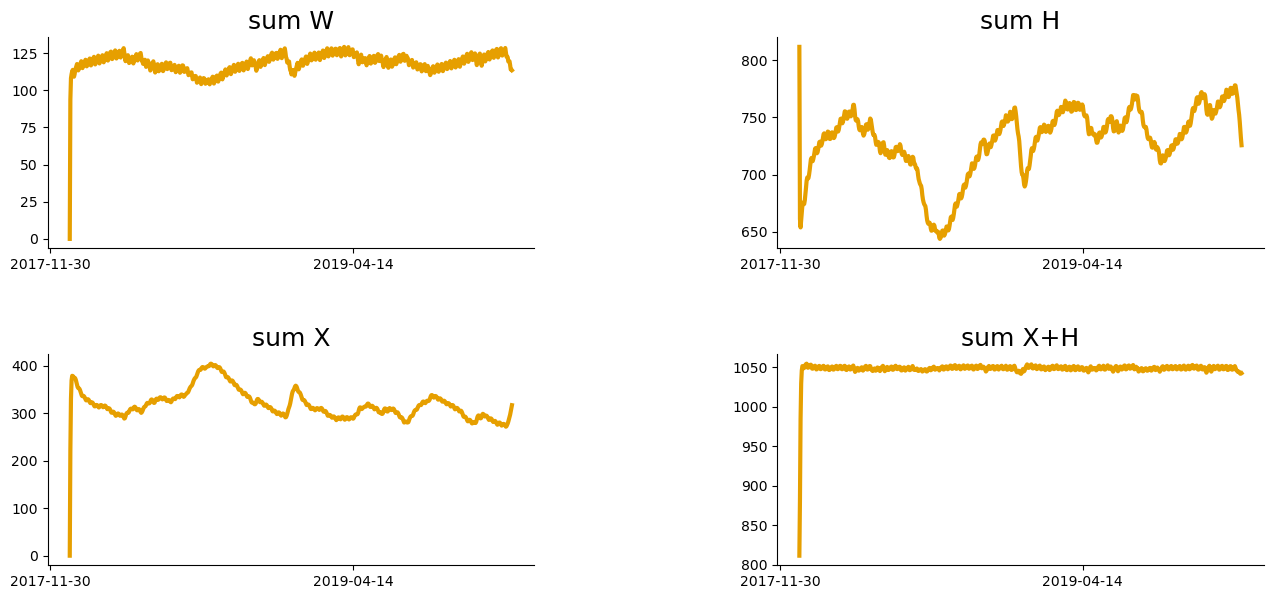

In [134]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state == 'X+H':
        out_plot = out.sum('MDC')['X'] + out.sum('MDC')['H']
    else:
        out_plot = out.sum('MDC')[state]
    axs[idx].plot(time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
#axs[0].set_yticks(ticks=[X_tot-50,X_tot,X_tot+50])
plt.show()


#### daily_hospitalizations 

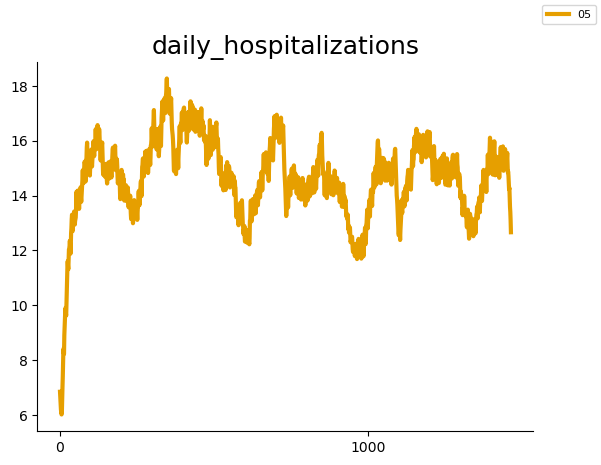

In [135]:
fig, ax = plt.subplots()
ax.set_title('daily_hospitalizations')
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
for idx,disease in enumerate(['05']):
    ax.plot(range(len(hospitalizations_per_day_before[disease])),hospitalizations_per_day_before[disease], label=disease)
fig.legend(fontsize=8)
plt.show()

#### normalized

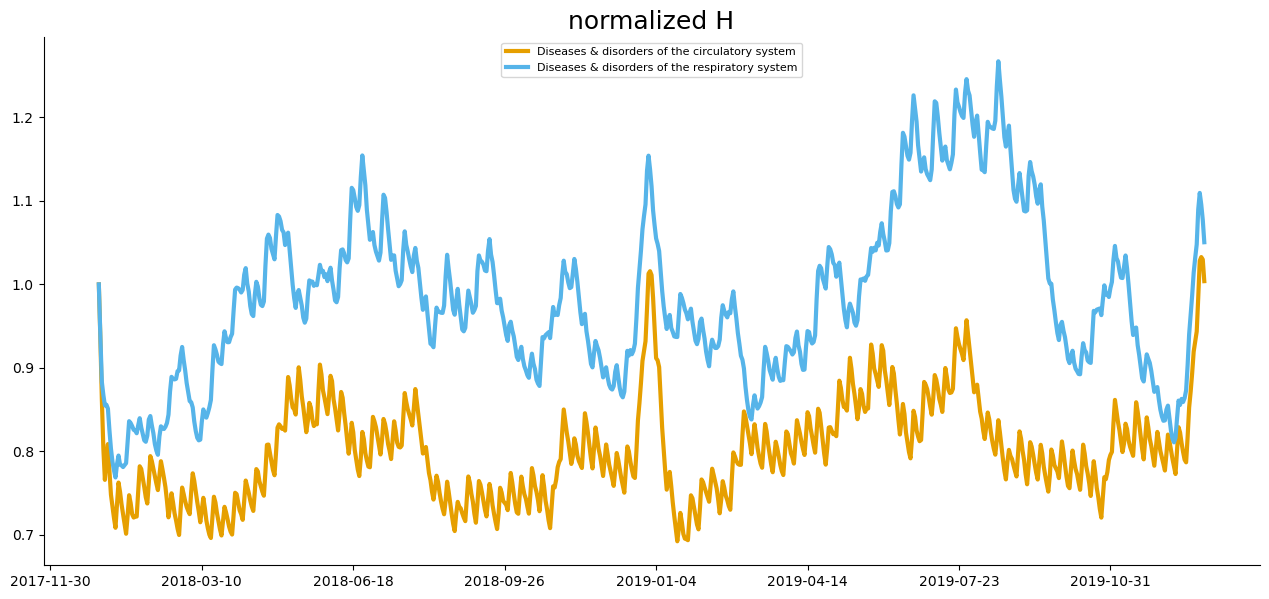

In [137]:
fix,ax=plt.subplots()

for disease in MDC_plot_classes:
    if disease=='04':
        out_plot = out.sel(MDC=disease)['H']+out.sel(MDC='covid')['H'].values
    else:
        out_plot = out.sel(MDC=disease)['H'].copy().values

    for idx, t in enumerate(time):
        week=t.isocalendar().week
        day=t.isocalendar().weekday
        out_plot[idx] = out_plot[idx]/hospitalization_baseline.loc[disease,week,day]
    out_plot = pd.DataFrame(out_plot).ewm(span=14).mean()
    ax.plot(time,out_plot, label=MDC_dict[disease])
    ax.set_title('normalized H')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

## Covid

### Parameters

In [ ]:
#set start and end date
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2022-01-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = MDC_keys.copy()

# Define model parameters, initial states and coordinates
beta = np.ones(len(MDC_classes))*0.01
gamma = mean_residence_times.loc[MDC_classes].values
epsilon = np.ones(len(MDC_classes))*0.1
sigma = np.ones(len(MDC_classes))*1
sigma[np.where(MDC_classes=='covid')]=10

X_tot = 1049
X_min = 1
daily_hospitalizations = hospitalizations_per_day_covid.loc[(MDC_classes,start_date.strftime('%Y-%m-%d'))].values

params={'daily_hospitalizations':daily_hospitalizations, 'X_tot':X_tot,'beta':beta, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma, 'MDC_keys':MDC_classes}

C:\Users\wolfd\AppData\Local\Temp\ipykernel_26324\1274639414.py:18: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  daily_hospitalizations = hospitalizations_per_day_covid.loc[(MDC_classes,start_date.strftime('%Y-%m-%d'))].values


### Initialize model

In [ ]:
H_init = hospitalization_baseline.loc[MDC_classes,start_date.isocalendar().week,start_date.isocalendar().weekday].values
H_init = np.insert(H_init,np.where(MDC_classes=='covid')[0],0)

#X_init = H_init + (X_tot-sum(H_init))/len(MDC_classes)
#start_string = start_date.strftime('%Y-%m-%d')
#W_init = hospitalizations_per_day_covid.loc[(MDC_classes[np.where(MDC_classes!='covid')],start_string)].values
#W_init = np.insert(W_init,np.where(MDC_classes=='covid')[0],0)
W_init = np.ones(len(MDC_classes))*0.001

init_states = {'H':H_init,'W':W_init}
coordinates=[MDC_classes,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'daily_hospitalizations': daily_hospitalizations_func})

C:\Users\wolfd\AppData\Local\Temp\ipykernel_26324\4085360704.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  H_init = hospitalization_baseline.loc[MDC_classes,start_date.isocalendar().week,start_date.isocalendar().weekday].values


### simulate model

In [ ]:
out_real_world_covid = model.sim(sim_len,start_date=start_date)

### plot results

In [ ]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2020-01-01')
plot_end_date = pd.to_datetime('2022-01-01')
time = pd.date_range(plot_start_date,plot_end_date)
out = out_real_world_covid.sel(time=time).copy()

X = []
for t in time:
    X.append(((X_tot-out.sel(time=t).sum('MDC_keys')['H']) * (sigma*out.sel(time=t)['W'])/sum(sigma*out.sel(time=t)['W'])).values)
X = np.array(X)

#### Covid

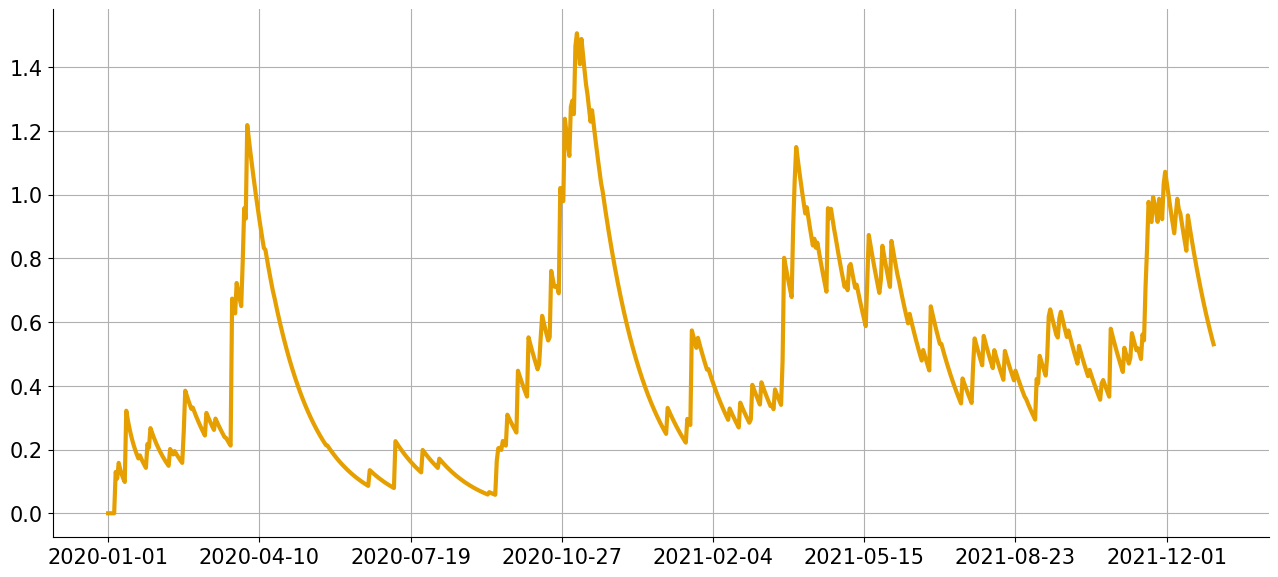

In [ ]:
fix,ax = plt.subplots()
ax.plot(covid_hospitalizations_per_day.index.get_level_values(0),covid_hospitalizations_per_day)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

#### States

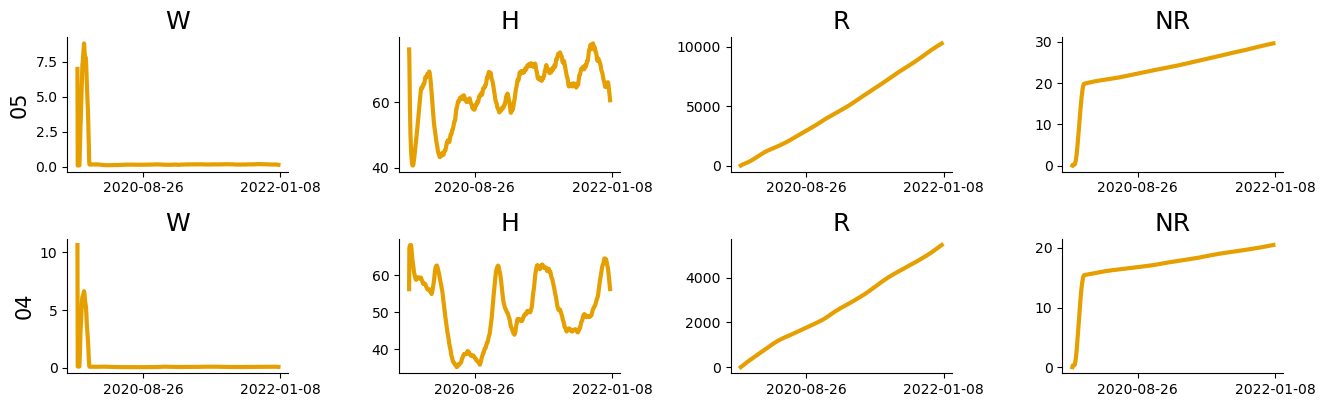

In [ ]:
fig, axs = plt.subplots(len(MDC_plot_classes),4)

for disease_idx, disease in enumerate(MDC_plot_classes):
    axs[disease_idx,0].set_ylabel(disease)
    for state_idx, state in enumerate(model.state_names):
        if disease=='04':
            out_plot = out.sel(MDC_keys=disease)[state]+out.sel(MDC_keys='covid')[state]
        else:
            out_plot = out.sel(MDC_keys=disease)[state].copy()
        axs[disease_idx,state_idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[disease_idx,state_idx].set_title(state)
        axs[disease_idx,state_idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[disease_idx,state_idx].grid(False)
        axs[disease_idx,state_idx].tick_params(axis='both', which='major', labelsize=10)
        axs[disease_idx,state_idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center',fontsize=8)
#plt.legend()
plt.show()

#### X-H

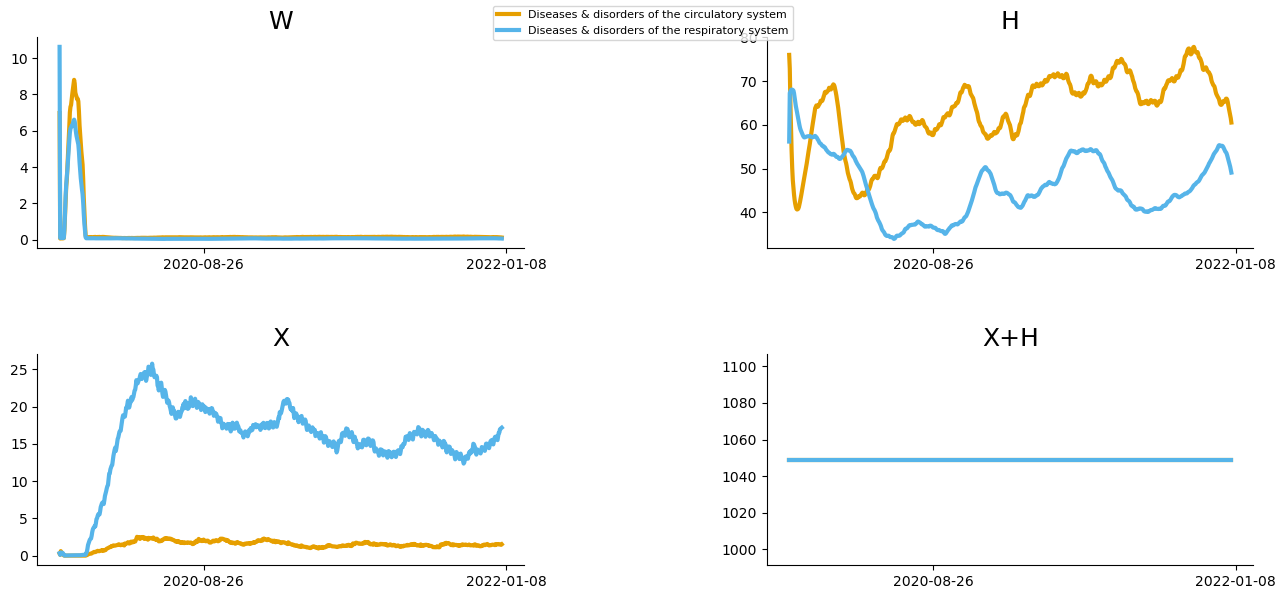

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X']):
    for dis_idx, disease in enumerate(MDC_plot_classes):
        if state=='X':
            #out_plot = out.sel(MDC_keys=disease)['X']+out.sel(MDC_keys=disease)['H']
            out_plot = X[:,dis_idx]
        else:
            out_plot = out.sel(MDC_keys=disease)[state].copy()
        axs[idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,fontsize=8,loc='upper center')
plt.show()

#### sum

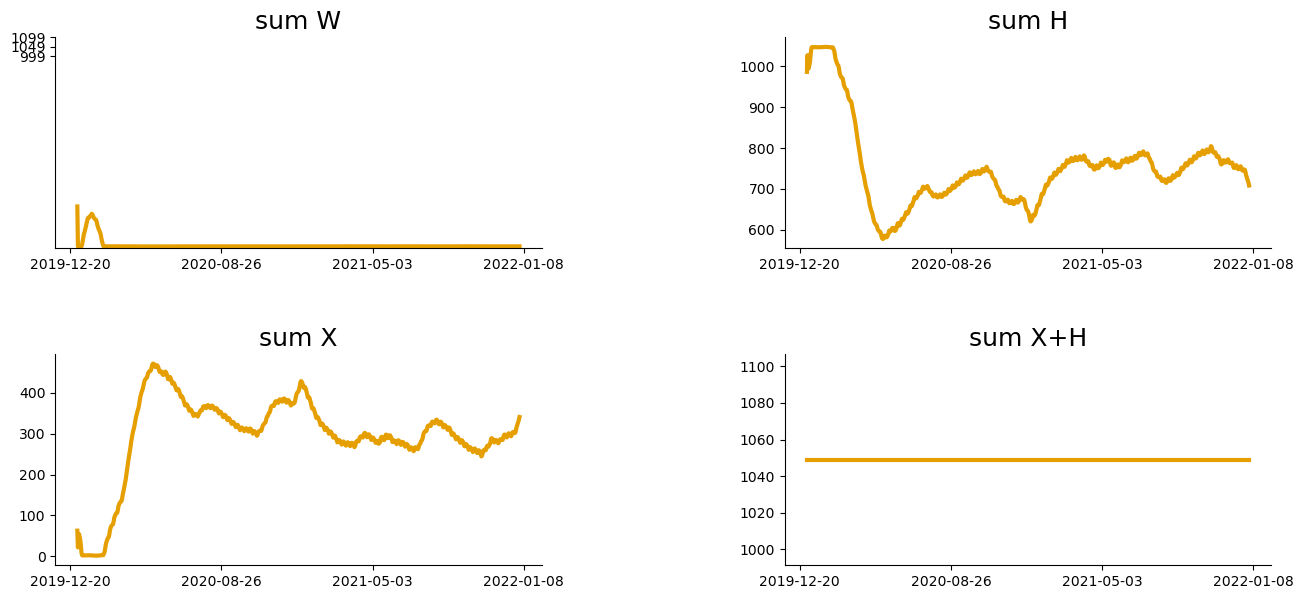

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state=='X':
        #out_plot = out.sum('MDC_keys')['X']-out.sum('MDC_keys')['H']
        out_plot = np.sum(X,axis=1)
    elif state == 'X+H':
        out_plot = np.sum(X,axis=1) + out.sum('MDC_keys')['H']
    else:
        out_plot = out.sum('MDC_keys')[state]
    axs[idx].plot(time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
axs[0].set_yticks(ticks=[X_tot-50,X_tot,X_tot+50])
plt.show()


#### daily hospitalizations

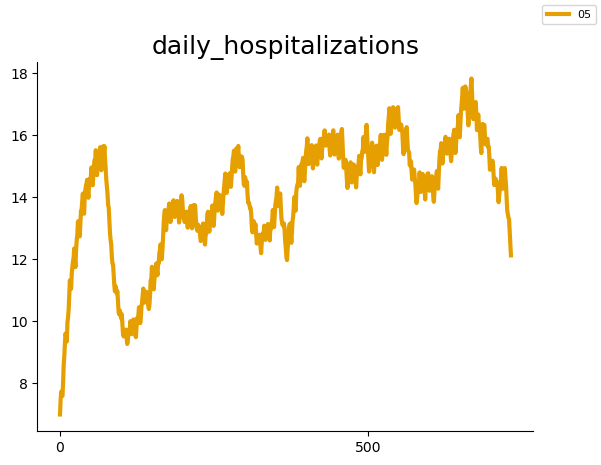

In [ ]:
fig, ax = plt.subplots()
ax.set_title('daily_hospitalizations')
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
for idx,disease in enumerate(['05']):
    ax.plot(range(len(hospitalizations_per_day_covid[disease])),hospitalizations_per_day_covid[disease], label=disease)
fig.legend(fontsize=8)
plt.show()

#### Normalized

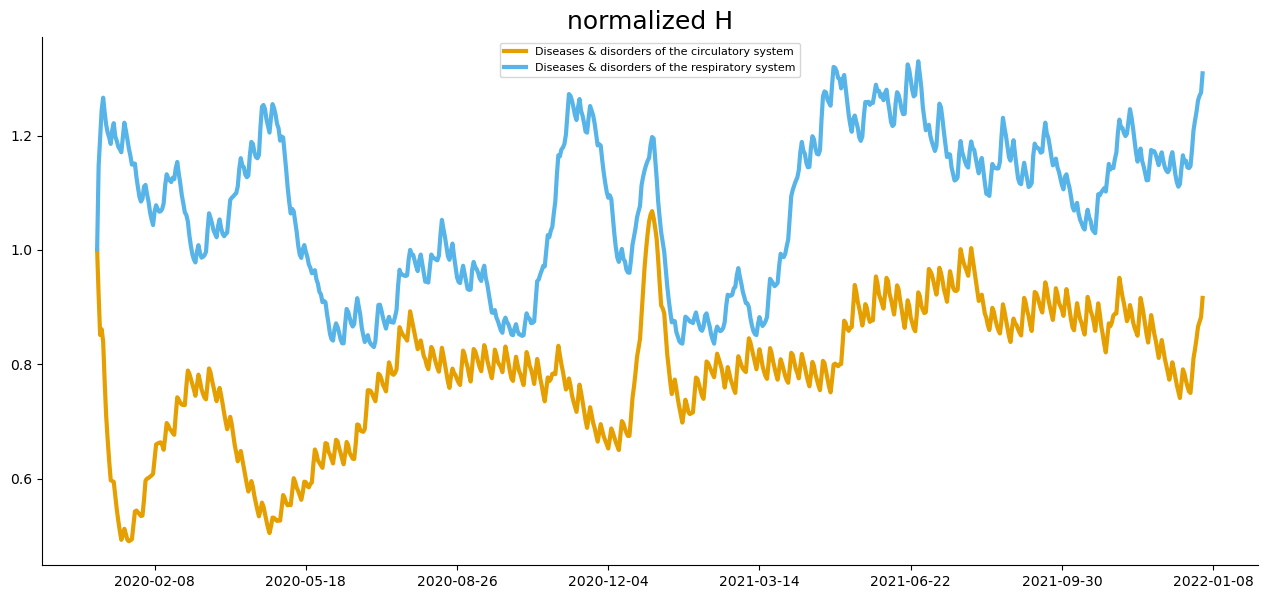

In [ ]:
fix,ax=plt.subplots()

for disease in MDC_plot_classes:
    if disease=='04':
        out_plot = out.sel(MDC_keys=disease)['H']+out.sel(MDC_keys='covid')['H'].values
    else:
        out_plot = out.sel(MDC_keys=disease)['H'].copy().values

    for idx, t in enumerate(time):
        week=t.isocalendar().week
        day=t.isocalendar().weekday
        out_plot[idx] = out_plot[idx]/hospitalization_baseline.loc[disease,week,day]
    out_plot = pd.DataFrame(out_plot).ewm(span=14).mean()
    ax.plot(time,out_plot, label=MDC_dict[disease])
    ax.set_title('normalized H')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

#### covid_H

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


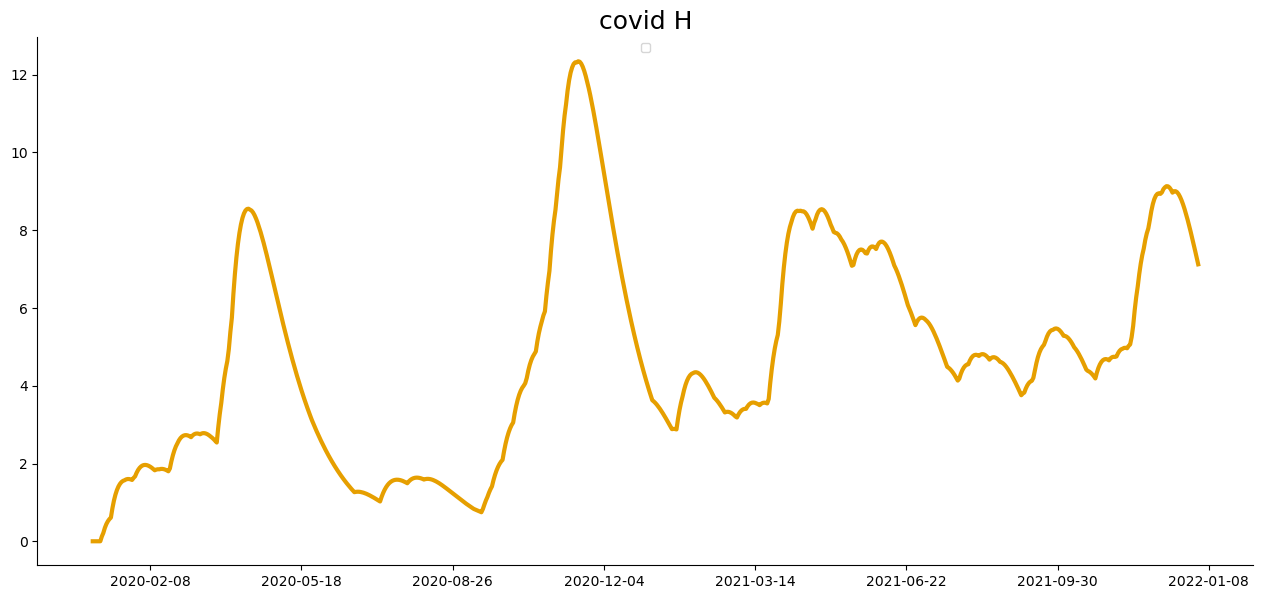

In [ ]:
fix,ax=plt.subplots()

ax.plot(time,out_real_world_covid.sel(MDC_keys='covid')['H'])
ax.set_title('covid H')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()